In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy

In [29]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# data
dataset_size = 7000
testset_size = 1000

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transform)

subset_indices = np.random.choice(len(train_dataset), dataset_size,
                                  replace=False)
train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=dataset_size)

data = next(iter(train_loader))
data_X = data[0].view(data[0].shape[0], -1).to(device)
data_y = data[1].to(device)

In [31]:
class StandardModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(StandardModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.layer_3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)

        return x

In [32]:
class VCLModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int,
                 starter_model: StandardModel):
        super(VCLModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.weights_bias_1_mean = nn.Parameter(
            torch.cat(
                [starter_model.layer_1.weight.data.clone().detach(),
                 starter_model.layer_1.bias.data.clone().detach().view(-1, 1)],
                dim=1))
        self.weights_bias_1_sd = nn.Parameter(
            torch.ones_like(self.weights_bias_1_mean) * 1e-6)

        self.weights_bias_2_mean = nn.Parameter(
            torch.cat(
                [starter_model.layer_2.weight.data.clone().detach(),
                 starter_model.layer_2.bias.data.clone().detach().view(-1, 1)],
                dim=1))
        self.weights_bias_2_sd = nn.Parameter(
            torch.ones_like(self.weights_bias_2_mean) * 1e-6)

        self.weights_bias_3_mean = nn.Parameter(
            torch.cat(
                [starter_model.layer_3.weight.data.clone().detach(),
                 starter_model.layer_3.bias.data.clone().detach().view(-1, 1)],
                dim=1))
        self.weights_bias_3_sd = nn.Parameter(
            torch.ones_like(self.weights_bias_3_mean) * 1e-6)

        self.weights_bias_1 = None
        self.weights_bias_2 = None
        self.weights_bias_3 = None

        self.prior_1_mean = torch.zeros_like(self.weights_bias_1_mean)
        self.prior_1_sd = torch.ones_like(self.weights_bias_1_mean)
        self.prior_2_mean = torch.zeros_like(self.weights_bias_2_mean)
        self.prior_2_sd = torch.ones_like(self.weights_bias_2_mean)
        self.prior_3_mean = torch.zeros_like(self.weights_bias_3_mean)
        self.prior_3_sd = torch.ones_like(self.weights_bias_3_mean)

    def sample_weights(self):
        self.reparam_1 = torch.randn_like(self.weights_bias_1_mean)
        self.reparam_2 = torch.randn_like(self.weights_bias_2_mean)
        self.reparam_3 = torch.randn_like(self.weights_bias_3_mean)

        self.weights_bias_1 = (
            self.weights_bias_1_mean + self.weights_bias_1_sd * self.reparam_1)
        self.weights_bias_2 = (
            self.weights_bias_2_mean + self.weights_bias_2_sd * self.reparam_2)
        self.weights_bias_3 = (
            self.weights_bias_3_mean + self.weights_bias_3_sd * self.reparam_3)

    def kl_loss(self):
        kl_loss = 0
        kl_loss += (torch.sum(self.weights_bias_1_sd.pow(2) / self.prior_1_sd.pow(2))
                    + torch.sum(self.weights_bias_2_sd.pow(2) / self.prior_2_sd.pow(2))
                    + torch.sum(self.weights_bias_3_sd.pow(2) / self.prior_3_sd.pow(2)))

        kl_loss += (
            torch.sum(
                (self.prior_1_mean - self.weights_bias_1_mean).pow(2)
                / self.prior_1_sd.pow(2))
            + torch.sum(
                (self.prior_2_mean - self.weights_bias_2_mean).pow(2)
                / self.prior_2_sd.pow(2))
            + torch.sum(
                (self.prior_3_mean - self.weights_bias_3_mean).pow(2)
                / self.prior_3_sd.pow(2)))

        kl_loss -= (self.prior_1_mean.shape[0] * self.prior_1_mean.shape[1]
                    + self.prior_2_mean.shape[0] * self.prior_2_mean.shape[1]
                    + self.prior_3_mean.shape[0] * self.prior_3_mean.shape[1])

        kl_loss += (
            torch.sum(torch.log(self.prior_1_sd.pow(2) / self.weights_bias_1_sd.pow(2)))
            + torch.sum(torch.log(self.prior_2_sd.pow(2) / self.weights_bias_2_sd.pow(2)))
            + torch.sum(torch.log(self.prior_3_sd.pow(2) / self.weights_bias_3_sd.pow(2))))
        kl_loss /= 2
        return kl_loss


    def forward(self, x):
        x = F.relu(
            x @ self.weights_bias_1[:, :-1].T + self.weights_bias_1[:, -1])
        x = F.relu(
            x @ self.weights_bias_2[:, :-1].T + self.weights_bias_2[:, -1])
        x = x @ self.weights_bias_3[:, :-1].T + self.weights_bias_3[:, -1]
        return x

In [33]:
def generate_task_data():
    random_perm = np.random.choice(28*28, 28*28, replace=False) # random pixel perm
    random_img_order = np.random.choice(data_X.shape[0], data_X.shape[0], replace=False) # random image order
    task_train_X = data_X[random_img_order].clone().detach()[:, random_perm][:-testset_size]
    task_test_X = data_X[random_img_order].clone().detach()[:, random_perm][-testset_size:]
    task_train_y = data_y[random_img_order].clone().detach()[:-testset_size]
    task_test_y = data_y[random_img_order].clone().detach()[-testset_size:]
    return task_train_X, task_test_X, task_train_y, task_test_y

# def generate_task_data():
#     random_perm = np.random.choice(3, 3, replace=False) # random pixel perm
#     random_img_order = np.random.choice(data_X.shape[0], data_X.shape[0], replace=False) # random image order
#     task_train_X = data_X[random_img_order].clone().detach()[:, random_perm][:-testset_size]
#     task_test_X = data_X[random_img_order].clone().detach()[:, random_perm][-testset_size:]
#     task_train_y = data_y[random_img_order].clone().detach()[:-testset_size]
#     task_test_y = data_y[random_img_order].clone().detach()[-testset_size:]
#     return task_train_X, task_test_X, task_train_y, task_test_y

In [34]:
class CustomDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

In [35]:
def evaluate_model(model, test_X, test_y, T=20):
    with torch.no_grad():
        model.sample_weights()
        outputs = model(test_X)

        for i in range(T):
            model.sample_weights()
            outputs += model(test_X)

        outputs /= T + 1
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == test_y).sum().item() / len(test_y)
        return accuracy

In [9]:
# classif_data = {}

In [37]:
coreset_sizes = [5000]

for coreset_size in coreset_sizes:
    print("Coreset Size: {}".format(coreset_size))


    starter_model = StandardModel(input_size=28*28, hidden_size=100, output_size=10).to(device)
    starter_optimizer = torch.optim.Adam(starter_model.parameters(), lr=1e-3)

    num_tasks = 10
    num_epochs = 100
    task_accuracy = []

    coreset_X, coreset_y= None, None
    test_X, test_y = None, None

    for task in range(num_tasks):
        print("Task {}:".format(task + 1))

        # observe new task dataset
        task_train_X, task_test_X, task_train_y, task_test_y = generate_task_data()

        if test_X is None:
            test_X = task_test_X
            test_y = task_test_y
        else:
            test_X = torch.cat((test_X, task_test_X), dim=0)
            test_y = torch.cat((test_y, task_test_y), dim=0)


        if task == 0:
            task_train_dataset = CustomDataset(task_train_X, task_train_y)
            task_train_dataloader = DataLoader(task_train_dataset, batch_size=256, shuffle=True)

            # train starter model
            log_softmax = nn.LogSoftmax(dim=1)
            loss_fn = nn.NLLLoss(reduction="mean")

            for epoch in range(num_epochs):
                for i, data in enumerate(task_train_dataloader):
                    batch_X, batch_y = data

                    starter_optimizer.zero_grad()
                    loss = loss_fn(input=log_softmax(starter_model(batch_X)),
                                target=batch_y)
                    loss.backward()
                    starter_optimizer.step()

                # if epoch % 10 == 9:
                #     outputs = starter_model(task_train_X)
                #     _, predicted = torch.max(outputs, 1)
                #     accuracy = (predicted == task_train_y).sum().item() / len(task_train_y)
                #     print("Starter Epoch {}: Accuracy {}".format(epoch + 1, accuracy))

            # initialize VCL model and priors
            model = VCLModel(input_size=28*28, hidden_size=100, output_size=10,
                            starter_model=starter_model).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # update the coreset, img order is already randomized
        if coreset_X is None:
            coreset_X = task_train_X[:coreset_size]
            coreset_y = task_train_y[:coreset_size]
        else:
            coreset_X = torch.cat((coreset_X, task_train_X[:coreset_size]), dim=0)
            coreset_y = torch.cat((coreset_y, task_train_y[:coreset_size]), dim=0)

        non_coreset_X = task_train_X[coreset_size:]
        non_coreset_y = task_train_y[coreset_size:]

        # update the variational distribution
        non_coreset_task_train_dataset = CustomDataset(non_coreset_X, non_coreset_y)
        non_coreset_task_train_dataloader = DataLoader(non_coreset_task_train_dataset,
                                                    batch_size=256, shuffle=True)
        log_softmax = nn.LogSoftmax(dim=1)
        loss_fn = nn.NLLLoss(reduction="sum")

        for epoch in range(num_epochs):
            for i, data in enumerate(non_coreset_task_train_dataloader):
                batch_X, batch_y = data

                model.sample_weights()

                optimizer.zero_grad()
                loss = loss_fn(input=log_softmax(model(batch_X)),
                            target= batch_y) * data_y.shape[0]
                loss += model.kl_loss()
                loss.backward()
                optimizer.step()

            # if epoch % 10 == 9:
            #     accuracy = evaluate_model(model, non_coreset_X, non_coreset_y)
            #     print("Variational Epoch {}: Accuracy {} Loss {}, NLL {}, KL Loss {}".format(
            #         epoch + 1,
            #         accuracy,
            #         int(loss.item()),
            #         int(loss_fn(input=log_softmax(model(batch_X)), target= batch_y).item() * data_y.shape[0]),
            #         int(model.kl_loss().item())))

        # update the final variational distribution
        predict_model = VCLModel(input_size=784, hidden_size=100, output_size=10,
                                starter_model=starter_model).to(device)
        predict_model.load_state_dict(model.state_dict())
        predict_optimizer = torch.optim.Adam(predict_model.parameters(), lr=1e-3)

        coreset_train_dataset = CustomDataset(coreset_X, coreset_y)
        coreset_train_dataloader = DataLoader(coreset_train_dataset,
                                            batch_size=256, shuffle=True)
        log_softmax = nn.LogSoftmax(dim=1)
        loss_fn = nn.NLLLoss(reduction="sum")

        for epoch in range(num_epochs):
            for i, data in enumerate(coreset_train_dataloader):
                batch_X, batch_y = data

                predict_model.sample_weights()

                predict_optimizer.zero_grad()
                loss = loss_fn(input=log_softmax(predict_model(batch_X)),
                            target= batch_y) * data_y.shape[0]

                loss += predict_model.kl_loss()

                loss.backward()
                predict_optimizer.step()

            # if epoch % 10 == 9:
            #     accuracy = evaluate_model(predict_model, coreset_X, coreset_y)
            #     print("Final Variational Epoch {}: Accuracy {} Loss {}, NLL {}, KL Loss {}".format(
            #         epoch + 1,
            #         accuracy,
            #         int(loss.item()),
            #         int(loss_fn(input=log_softmax(predict_model(batch_X)), target= batch_y).item() * data_y.shape[0]),
            #         int(predict_model.kl_loss().item())))

        task_accuracy.append(evaluate_model(predict_model, test_X, test_y))
        print("Current Task Accuracy", task_accuracy)

        # update the prior
        model.prior_1_mean = model.weights_bias_1_mean.clone().detach()
        model.prior_1_sd = model.weights_bias_1_sd.clone().detach()
        model.prior_2_mean = model.weights_bias_2_mean.clone().detach()
        model.prior_2_sd = model.weights_bias_2_sd.clone().detach()
        model.prior_3_mean = model.weights_bias_3_mean.clone().detach()
        model.prior_3_sd = model.weights_bias_3_sd.clone().detach()

    classif_data[coreset_size] = task_accuracy

Coreset Size: 5000
Task 1:
Current Task Accuracy [0.937]
Task 2:
Current Task Accuracy [0.937, 0.949]
Task 3:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334]
Task 4:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825]
Task 5:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825, 0.944]
Task 6:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825, 0.944, 0.9448333333333333]
Task 7:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825, 0.944, 0.9448333333333333, 0.9398571428571428]
Task 8:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825, 0.944, 0.9448333333333333, 0.9398571428571428, 0.942125]
Task 9:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825, 0.944, 0.9448333333333333, 0.9398571428571428, 0.942125, 0.9446666666666667]
Task 10:
Current Task Accuracy [0.937, 0.949, 0.9463333333333334, 0.94825, 0.944, 0.9448333333333333, 0.9398571428571428, 0.942125, 0.9446666666666667, 0.9427]


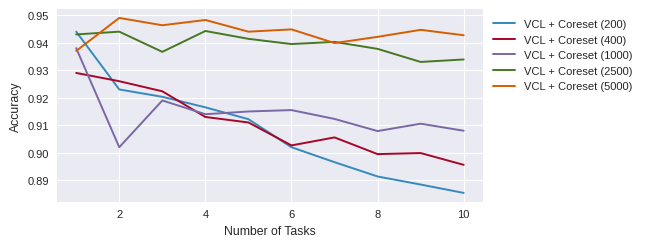

In [89]:
plt.style.use("seaborn-v0_8-paper")
plt.figure(figsize=(5.5, 2.5))

for coreset_size in classif_data.keys():
    plt.plot(np.arange(1, len(classif_data[coreset_size]) + 1), classif_data[coreset_size], label=("VCL + Coreset ({})".format(coreset_size)))

plt.ylabel("Accuracy")
plt.xlabel("Number of Tasks")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Regression

In [91]:
# data
dataset_size = 7000
testset_size = 1000

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

subset_indices = np.random.choice(len(train_dataset), dataset_size, replace=False)
train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=dataset_size)

data = next(iter(train_loader))
data_X = data[0].view(data[0].shape[0], -1).to(device)
data_y = F.one_hot(data[1]).to(device=device, dtype=torch.float32)

In [99]:
def evaluate_reg_model(model, test_X, test_y, T=20):
    with torch.no_grad():
        model.sample_weights()
        outputs = model(test_X)

        for i in range(T):
            model.sample_weights()
            outputs += model(test_X)

        outputs /= T + 1
        rmse = F.mse_loss(outputs, test_y) ** 0.5
        return rmse

In [100]:
class VCLModelRegression(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, starter_model: StandardModel):
        super(VCLModelRegression, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.weights_bias_1_mean = nn.Parameter(
            torch.cat(
                [starter_model.layer_1.weight.data.clone().detach(),
                 starter_model.layer_1.bias.data.clone().detach().view(-1, 1)],
                dim=1)
        )
        self.weights_bias_1_sd = nn.Parameter(
            torch.ones_like(self.weights_bias_1_mean) * 1e-6)

        self.weights_bias_2_mean = nn.Parameter(
            torch.cat(
                [starter_model.layer_2.weight.data.clone().detach(),
                 starter_model.layer_2.bias.data.clone().detach().view(-1, 1)],
                dim=1)
        )
        self.weights_bias_2_sd = nn.Parameter(
            torch.ones_like(self.weights_bias_2_mean) * 1e-6)

        self.weights_bias_3_mean = nn.Parameter(
            torch.cat(
                [starter_model.layer_3.weight.data.clone().detach(),
                 starter_model.layer_3.bias.data.clone().detach().view(-1, 1)],
                dim=1)
        )
        self.weights_bias_3_sd = nn.Parameter(
            torch.ones_like(self.weights_bias_3_mean) * 1e-6)

        self.weights_bias_1 = None
        self.weights_bias_2 = None
        self.weights_bias_3 = None

        self.prior_1_mean = torch.zeros_like(self.weights_bias_1_mean)
        self.prior_1_sd = torch.ones_like(self.weights_bias_1_mean)
        self.prior_2_mean = torch.zeros_like(self.weights_bias_2_mean)
        self.prior_2_sd = torch.ones_like(self.weights_bias_2_mean)
        self.prior_3_mean = torch.zeros_like(self.weights_bias_3_mean)
        self.prior_3_sd = torch.ones_like(self.weights_bias_3_mean)

        self.likelihood_var = nn.Parameter(torch.ones(1))

    def sample_weights(self):
        self.reparam_1 = torch.randn_like(self.weights_bias_1_mean)
        self.reparam_2 = torch.randn_like(self.weights_bias_2_mean)
        self.reparam_3 = torch.randn_like(self.weights_bias_3_mean)

        self.weights_bias_1 = (
            self.weights_bias_1_mean + self.weights_bias_1_sd * self.reparam_1)
        self.weights_bias_2 = (
            self.weights_bias_2_mean + self.weights_bias_2_sd * self.reparam_2)
        self.weights_bias_3 = (
            self.weights_bias_3_mean + self.weights_bias_3_sd * self.reparam_3)

    def kl_loss(self):
        kl_loss = 0
        kl_loss += (
            torch.sum(self.weights_bias_1_sd.pow(2) / self.prior_1_sd.pow(2))
            + torch.sum(self.weights_bias_2_sd.pow(2) / self.prior_2_sd.pow(2))
            + torch.sum(+ self.weights_bias_3_sd.pow(2) / self.prior_3_sd.pow(2)))
        kl_loss += (
            torch.sum((self.prior_1_mean - self.weights_bias_1_mean).pow(2) / self.prior_1_sd.pow(2))
            + torch.sum((self.prior_2_mean - self.weights_bias_2_mean).pow(2) / self.prior_2_sd.pow(2))
            + torch.sum((self.prior_3_mean - self.weights_bias_3_mean).pow(2) / self.prior_3_sd.pow(2)))
        kl_loss -= (self.prior_1_mean.shape[0] * self.prior_1_mean.shape[1]
                    + self.prior_2_mean.shape[0] * self.prior_2_mean.shape[1]
                    + self.prior_3_mean.shape[0] * self.prior_3_mean.shape[1])
        kl_loss += (
            torch.sum(torch.log(self.prior_1_sd.pow(2) / self.weights_bias_1_sd.pow(2)))
            + torch.sum(torch.log(self.prior_2_sd.pow(2) / self.weights_bias_2_sd.pow(2)))
            + torch.sum(torch.log(self.prior_3_sd.pow(2) / self.weights_bias_3_sd.pow(2))))
        kl_loss /= 2
        return kl_loss


    def forward(self, x):
        x = F.relu(x @ self.weights_bias_1[:, :-1].T + self.weights_bias_1[:, -1])
        x = F.relu(x @ self.weights_bias_2[:, :-1].T + self.weights_bias_2[:, -1])
        x = x @ self.weights_bias_3[:, :-1].T + self.weights_bias_3[:, -1]
        return x

In [94]:
# reg_data = {}

In [113]:
coreset_sizes = [5000]

for coreset_size in coreset_sizes:
    print("Coreset Size: {}".format(coreset_size))

    starter_model = StandardModel(input_size=28*28, hidden_size=100, output_size=10).to(device)
    starter_optimizer = torch.optim.Adam(starter_model.parameters(), lr=1e-3)

    num_tasks = 10
    num_epochs = 100
    task_accuracy = []

    coreset_X, coreset_y= None, None
    test_X, test_y = None, None

    for task in range(num_tasks):
        print("Task {}:".format(task + 1))

        # observe new task dataset
        task_train_X, task_test_X, task_train_y, task_test_y = generate_task_data()

        if test_X is None:
            test_X = task_test_X
            test_y = task_test_y
        else:
            test_X = torch.cat((test_X, task_test_X), dim=0)
            test_y = torch.cat((test_y, task_test_y), dim=0)


        if task == 0:
            task_train_dataset = CustomDataset(task_train_X, task_train_y)
            task_train_dataloader = DataLoader(task_train_dataset, batch_size=256, shuffle=True)

            # train starter model
            loss_fn = nn.MSELoss(reduction='sum')

            for epoch in range(num_epochs):
                for i, data in enumerate(task_train_dataloader):
                    batch_X, batch_y = data

                    starter_optimizer.zero_grad()
                    loss = loss_fn(input=starter_model(batch_X), target= batch_y)
                    loss.backward()
                    starter_optimizer.step()

                # if epoch % 10 == 9:
                #     outputs = starter_model(task_train_X)
                #     _, predicted = torch.max(outputs, 1)
                #     accuracy = (predicted == task_train_y).sum().item() / len(task_train_y)
                #     print("Starter Epoch {}: Accuracy {}".format(epoch + 1, accuracy))

            # initialize VCL model and priors
            model = VCLModelRegression(input_size=28*28, hidden_size=100, output_size=10,
                            starter_model=starter_model).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        # update the coreset, img order is already randomized
        if coreset_X is None:
            coreset_X = task_train_X[:coreset_size]
            coreset_y = task_train_y[:coreset_size]
        else:
            coreset_X = torch.cat((coreset_X, task_train_X[:coreset_size]), dim=0)
            coreset_y = torch.cat((coreset_y, task_train_y[:coreset_size]), dim=0)

        non_coreset_X = task_train_X[coreset_size:]
        non_coreset_y = task_train_y[coreset_size:]

        # update the variational distribution
        non_coreset_task_train_dataset = CustomDataset(non_coreset_X, non_coreset_y)
        non_coreset_task_train_dataloader = DataLoader(non_coreset_task_train_dataset,
                                                    batch_size=256, shuffle=True)

        loss_fn = nn.MSELoss(reduction='sum')

        for epoch in range(num_epochs):
            for i, data in enumerate(non_coreset_task_train_dataloader):
                batch_X, batch_y = data

                model.sample_weights()

                optimizer.zero_grad()
                loss = (
                    data_y.shape[0] * loss_fn(input=model(batch_X), target= batch_y)
                    / (2 * model.likelihood_var)
                    + data_y.shape[0] * 10 * torch.log(2 * np.pi * model.likelihood_var) / 2
                    + model.kl_loss())
                loss.backward()
                optimizer.step()

            # if epoch % 10 == 9:
            #     mse = evaluate_reg_model(model, non_coreset_X, non_coreset_y)
            #     print("Variational Epoch {}: MSE {} Loss {}".format(
            #         epoch + 1,
            #         mse,
            #         int(loss.item())))

        # update the final variational distribution
        predict_model = VCLModelRegression(input_size=784, hidden_size=100, output_size=10,
                                starter_model=starter_model).to(device)
        predict_model.load_state_dict(model.state_dict())
        predict_optimizer = torch.optim.Adam(predict_model.parameters(), lr=1e-3)

        coreset_train_dataset = CustomDataset(coreset_X, coreset_y)
        coreset_train_dataloader = DataLoader(coreset_train_dataset,
                                            batch_size=256, shuffle=True)

        loss_fn = nn.MSELoss(reduction='sum')

        for epoch in range(num_epochs):
            for i, data in enumerate(coreset_train_dataloader):
                batch_X, batch_y = data

                predict_model.sample_weights()

                predict_optimizer.zero_grad()
                loss = (
                    data_y.shape[0] * loss_fn(input=predict_model(batch_X), target= batch_y)
                    / (2 * predict_model.likelihood_var)
                    + data_y.shape[0] * 10 * torch.log(2 * np.pi * predict_model.likelihood_var) / 2
                    + predict_model.kl_loss())

                loss.backward()
                predict_optimizer.step()

            # if epoch % 10 == 9:
            #     mse = evaluate_reg_model(model, non_coreset_X, non_coreset_y)
            #     print("Final Variational Epoch {}: MSE {} Loss {}".format(
            #         epoch + 1,
            #         mse,
            #         int(loss.item())))

        task_accuracy.append(evaluate_reg_model(predict_model, test_X, test_y).item())
        print("Current Task RMSE", task_accuracy)

        # update the prior
        model.prior_1_mean = model.weights_bias_1_mean.clone().detach()
        model.prior_1_sd = model.weights_bias_1_sd.clone().detach()
        model.prior_2_mean = model.weights_bias_2_mean.clone().detach()
        model.prior_2_sd = model.weights_bias_2_sd.clone().detach()
        model.prior_3_mean = model.weights_bias_3_mean.clone().detach()
        model.prior_3_sd = model.weights_bias_3_sd.clone().detach()
    reg_data[coreset_size] = task_accuracy

Coreset Size: 5000
Task 1:
Current Task RMSE [0.08846429735422134]
Task 2:
Current Task RMSE [0.08846429735422134, 0.08899087458848953]
Task 3:
Current Task RMSE [0.08846429735422134, 0.08899087458848953, 0.09259341657161713]
Task 4:
Current Task RMSE [0.08846429735422134, 0.08899087458848953, 0.09259341657161713, 0.09163220971822739]
Task 5:
Current Task RMSE [0.08846429735422134, 0.08899087458848953, 0.09259341657161713, 0.09163220971822739, 0.09311895072460175]
Task 6:
Current Task RMSE [0.08846429735422134, 0.08899087458848953, 0.09259341657161713, 0.09163220971822739, 0.09311895072460175, 0.09599129855632782]
Task 7:
Current Task RMSE [0.08846429735422134, 0.08899087458848953, 0.09259341657161713, 0.09163220971822739, 0.09311895072460175, 0.09599129855632782, 0.10153302550315857]
Task 8:
Current Task RMSE [0.08846429735422134, 0.08899087458848953, 0.09259341657161713, 0.09163220971822739, 0.09311895072460175, 0.09599129855632782, 0.10153302550315857, 0.10253876447677612]
Task 9:
C

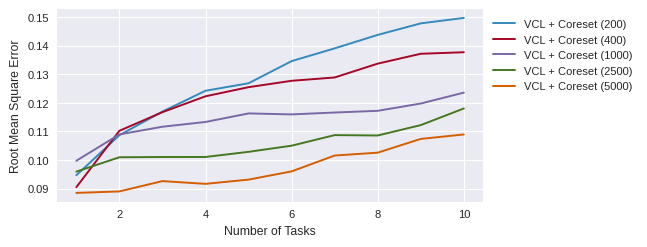

In [114]:
plt.style.use("seaborn-v0_8-paper")
plt.figure(figsize=(5.5, 2.5))

for coreset_size in reg_data.keys():
    plt.plot(np.arange(1, len(reg_data[coreset_size]) + 1), reg_data[coreset_size], label=("VCL + Coreset ({})".format(coreset_size)))

plt.ylabel("Root Mean Square Error")
plt.xlabel("Number of Tasks")
plt.legend(bbox_to_anchor=(1,1))
plt.show()